In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

file_path = "drive/My Drive/Colab Notebooks/date.txt"

input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
  date_list = f.readlines()
  for date in date_list:
    date = date[:-1]
    input_date.append(date.split("_")[0])
    output_date.append("_" + date.split("_")[1])

# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0])
output_len = len(output_date[0])

# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
  for c in input_chars:
    if not c in char2id:
      char2id[c] = len(char2id)
  for c in output_chars:
    if not c in char2id:
      char2id[c] = len(char2id)

input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
  input_data.append([char2id[c] for c in input_chars])
  output_data.append([char2id[c] for c in output_chars])

# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

# データをバッチ化するための関数
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

In [0]:
# from sklearn.model_selection import train_test_split
# import random
# from sklearn.utils import shuffle


# # 数字の文字をID化
# char2id = {str(i) : i for i in range(10)}

# # 空白(10)：系列の長さを揃えるようのパディング文字
# # -(11)：マイナスの文字
# # _(12)：系列生成開始を知らせる文字
# char2id.update({" ":10, "-":11, "_":12})

# # 空白込みの３桁の数字をランダムに生成
# def generate_number():
#     number = [random.choice(list("0123456789")) for _ in range(random.randint(1, 3))]
#     return int("".join(number))

# # 確認
# print(generate_number())

# # 系列の長さを揃えるために空白パディング
# def add_padding(number, is_input=True):
#     number = "{: <7}".format(number) if is_input else "{: <5s}".format(number)
#     return number

# # 確認
# num = generate_number()
# print("\"" + str(add_padding(num)) + "\"")
# print(len(add_padding(num)))

# # データ準備
# input_data = []
# output_data = []

# # データを５００００件準備する
# while len(input_data) < 50000:
#     x = generate_number()
#     y = generate_number()
#     z = x - y
#     input_char = add_padding(str(x) + "-" + str(y))
#     output_char = add_padding("_" + str(z), is_input=False)
    
#     # データをIDにに変換
#     input_data.append([char2id[c] for c in input_char])
#     output_data.append([char2id[c] for c in output_char])
    
# # 確認
# print(input_data[987])
# print(output_data[987])

# input_len = len(input_data[0])
# output_len = len(output_data[0])

# # ７：３にデータをわける
# train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)


# # データをバッチ化するための関数
# def train2batch(input_data, output_data, batch_size=100):
#     input_batch = []
#     output_batch = []
#     input_shuffle, output_shuffle = shuffle(input_data, output_data)
#     for i in range(0, len(input_data), batch_size):
#       input_batch.append(input_shuffle[i:i+batch_size])
#       output_batch.append(output_shuffle[i:i+batch_size])
#     return input_batch, output_batch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 200
hidden_dim = 128
BATCH_NUM = 100
vocab_size = len(char2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
    
    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # hsが各系列のGRUの隠れ層のベクトル
        # Attentionされる要素
        hs, h = self.gru(embedding)
        return hs, h


# AttentionDecoderクラス
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)

       # Attention
       # bmmを使ってEncoder側の出力(hs)とDecoder側の出力(output)をbatchごとまとめて行列計算するために、Decoder側のoutputをbatchを固定して転置行列を取る
        t_output = torch.transpose(output, 1, 2)
        # bmmでバッチも考慮してまとめて行列計算
        s = torch.bmm(hs, t_output)
        # 列方向(dim=1)でsoftmaxをとって確率表現に変換
        # この値を後のAttentionの可視化などにも使う
        attention_weight = self.softmax(s)

        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device)
        for i in range(attention_weight.size()[2]):
          unsq_weight = attention_weight[:,:,i].unsqueeze(2)
          weighted_hs = hs * unsq_weight
          weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1)
          c = torch.cat([c, weight_sum], dim=1)
        # 箱として用意したzero要素が残っているのでスライスして削除
        c = c[:,1:,:]
        
        output = torch.cat([output, c], dim=2)
        output = self.hidden2linear(output)
        return output, state, attention_weight

encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
attn_decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=0.001)

In [61]:
# 学習

BATCH_NUM=100
EPOCH_NUM = 100

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)
    for i in range(len(input_batch)):
        
        # 勾配の初期化
        encoder_optimizer.zero_grad()
        attn_decoder_optimizer.zero_grad()
        
        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)
        
        # Encoderの順伝搬
        hs, h = encoder(input_tensor)

        # Attention Decoderのインプット
        source = output_tensor[:, :-1]
        
        # Attention Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _, attention_weight= attn_decoder(source, hs, h)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()
        
        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        encoder_optimizer.step()
        attn_decoder_optimizer.step()
    
    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 0.1: break
print("Done")

training ...
Epoch 1: 1500.33
Epoch 2: 77.53
Epoch 3: 12.98
Epoch 4: 3.40
Epoch 5: 1.78
Epoch 6: 1.13
Epoch 7: 0.78
Epoch 8: 0.56
Epoch 9: 0.42
Epoch 10: 0.32
Epoch 11: 0.25
Epoch 12: 0.20
Epoch 13: 0.16
Epoch 14: 0.13
Epoch 15: 0.11
Epoch 16: 0.09
Done


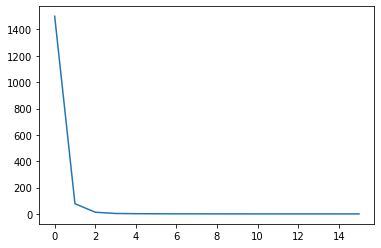

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

In [0]:
BATCH_NUM=100

# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)
    
# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
  with torch.no_grad():
    hs, encoder_state = encoder(input_tensor[i])
    
    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    decoder_hidden = encoder_state
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    for _ in range(output_len - 1):
      decoder_output, decoder_hidden, _ = attn_decoder(decoder_input_tensor, hs, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
    predicts.append(batch_tmp[:,1:])

In [0]:
import pandas as pd
# id2char = {str(i) : str(i) for i in range(10)}
# id2char.update({"10":"", "11":"-", "12":""})
id2char = {}
for k, v in char2id.items():
  id2char[v] = k
row = []
for i in range(len(test_input_batch)):
  batch_input = test_input_batch[i]
  batch_output = test_output_batch[i]
  batch_predict = predicts[i]
  for inp, output, predict in zip(batch_input, batch_output, batch_predict):
    x = [id2char[idx] for idx in inp]
    y = [id2char[idx] for idx in output[1:]]
    p = [id2char[idx.item()] for idx in predict]
    
    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)
    
    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])

In [68]:
predict_df.head()

,input,answer,predict,judge
0,11/7/72,1972-11-07,1972-11-07,O
1,"May 12, 1973",1973-05-12,1973-05-12,O
2,"Jan 10, 1995",1995-01-10,1995-01-10,O
3,"February 10, 1997",1997-02-10,1997-02-10,O
4,7/13/08,2008-07-13,2008-07-13,O


In [69]:
print(len(predict_df.query('judge == "O"')) / len(predict_df))
predict_df.query('judge == "X"').head(10)

0.9999333333333333


,input,answer,predict,judge
7399,8/3/02,2002-08-03,2002-08-02,X


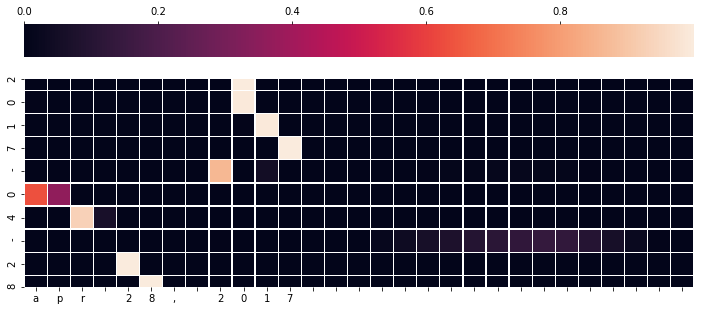

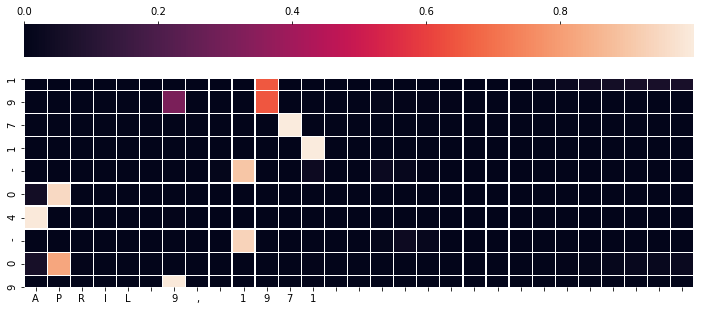

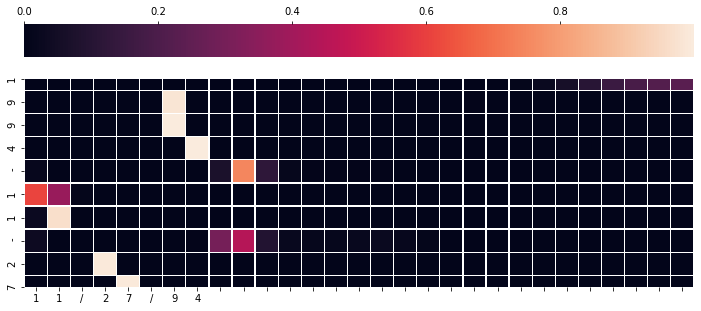

In [79]:
import seaborn as sns
import pandas as pd

input_batch, output_batch = train2batch(test_x, test_y, batch_size=BATCH_NUM)
input_minibatch, output_minibatch = input_batch[0], output_batch[0]

with torch.no_grad():
  # データをテンソルに変換
  input_tensor = torch.tensor(input_minibatch, device=device)
  output_tensor = torch.tensor(output_minibatch, device=device)
  hs, h = encoder(input_tensor)
  source = output_tensor[:, :-1]
  decoder_output, _, attention_weight= attn_decoder(source, hs, h)


for i in range(3):
  with torch.no_grad():
    df = pd.DataFrame(data=torch.transpose(attention_weight[i], 0, 1).cpu().numpy(), 
                      columns=[id2char[idx.item()] for idx in input_tensor[i]], 
                      index=[id2char[idx.item()] for idx in output_tensor[i][1:]])
    plt.figure(figsize=(12, 8)) 
    sns.heatmap(df, xticklabels = 1, yticklabels = 1, square=True, linewidths=.3,cbar_kws = dict(use_gridspec=False,location="top"))

In [0]:
import torch
import torch.nn as nn
import numpy as np

hs = torch.rand(2, 3,4)
# print("hs")
# print(hs)

key = torch.rand(2, 2, 4)
# print("key")
# print(key)
t_key = torch.transpose(key, 1, 2)
n = torch.bmm(hs, t_key)
# print("n")
# print(n)

softmax = nn.Softmax(dim=1)
p = softmax(n)


# print(hs)
# print(p)
# print(hs.size(), p.size())
# print(p.size()[2])
s = torch.zeros(2,1,4, dtype=torch.float32)
for i in range(p.size()[2]):
  un_p = p[:,:,i].unsqueeze(2)
  w = hs * un_p
  ww = torch.sum(w, axis=1).unsqueeze(1)
  # print(ww)
  s = torch.cat([s, ww], dim=1)
s = s[:,1:,:]
print(key)
print(s)
torch.cat([key, s], dim=2)

tensor([[[0.8501, 0.4943, 0.9450, 0.0287],
         [0.2494, 0.3280, 0.4441, 0.5072]],

        [[0.5788, 0.3693, 0.7892, 0.2889],
         [0.0578, 0.5105, 0.3870, 0.1541]]])
tensor([[[0.4585, 0.3846, 0.4525, 0.4942],
         [0.4679, 0.4341, 0.3947, 0.5777]],

        [[0.4258, 0.5800, 0.2113, 0.3429],
         [0.4235, 0.5883, 0.2150, 0.3435]]])


tensor([[[0.8501, 0.4943, 0.9450, 0.0287, 0.4585, 0.3846, 0.4525, 0.4942],
         [0.2494, 0.3280, 0.4441, 0.5072, 0.4679, 0.4341, 0.3947, 0.5777]],

        [[0.5788, 0.3693, 0.7892, 0.2889, 0.4258, 0.5800, 0.2113, 0.3429],
         [0.0578, 0.5105, 0.3870, 0.1541, 0.4235, 0.5883, 0.2150, 0.3435]]])

In [0]:
a = torch.rand(2,3)
b = torch.rand(2,3)
print(a.unsqueeze_(1))
print(b.unsqueeze_(1))
torch.cat([a,b], dim=1).size()

tensor([[[0.7436, 0.4357, 0.7493]],

        [[0.6501, 0.1284, 0.7942]]])
tensor([[[0.4423, 0.7633, 0.8567]],

        [[0.3018, 0.4749, 0.5613]]])


torch.Size([2, 2, 3])